Simulation of the CMB instrument
====

The routines and classes to simulate a CMB instrument are gathered in instrument.py.
More specifically this module is used to generate the hardware (focal plane geometry, readout, bolometers, wiring, etc.), the calibration models (pointing, beam, polarisation angle), and control the HWP. In the following, we will review all those:
* Focal plane.
* Polarisation angle of the bolometers.
* Beam parameters of the bolometers.
* Pointing model parameters of the telescope.
* Half-wave plate (continously rotated or stepped).

In [1]:
## Import basic modules and routines
from __future__ import division, absolute_import, print_function

## In case you did not install properly the library 
## or didn't update your bashrc. (Do it later!)
import os
path_to_s4cmb = '../../s4cmb'
os.sys.path.insert(0, os.path.realpath(path_to_s4cmb))

import numpy as np
import pylab as pl

** General instrument **

Let's generate a square focal plane (60 cm wide, 3 degrees on the sky) with 4 Crate boards, each with 1 MUX board, 
each with 1 Squid, each with 16 pairs of bolometers.
Each detector beam is Gaussian with FWHM of 3.5 arcmin.
We chose a 5 parameters pointing model (Mangum 2001).
Finally we mount a Continously Rotating Half-Wave Plate, spinning at 2 Hz.
See http://simonsobservatory.wikidot.com/instrument-systmodule for more informations.

In [2]:
from s4cmb import instrument

inst = instrument.Hardware(ncrate=4, ndfmux_per_crate=1,
                           nsquid_per_mux=1, npair_per_squid=16,
                           fp_size=60., fwhm=3.5, 
                           beam_seed=58347, projected_fp_size=3., pm_name='5params',
                           type_hwp='CRHWP', freq_hwp=2., angle_hwp=0., verbose=False)

** Focal Plane **

Let's have a look at our focal plane. As expected it is squared, 60 cm wide,
with bolometers evenly spaced. Notice that 2 bolometers on the same pair
(top and bottom) sit on top of each other.

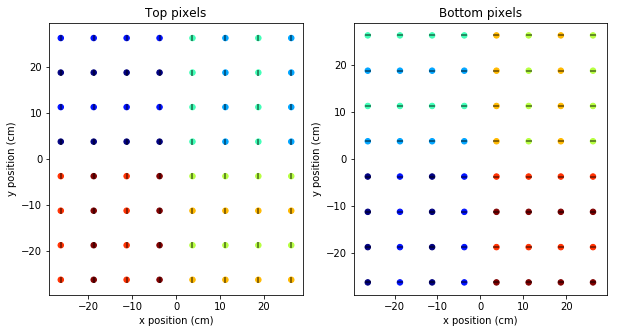

In [3]:
from s4cmb.instrument import show_focal_plane

fp = inst.focal_plane
show_focal_plane(fp.bolo_xcoord, fp.bolo_ycoord, fp.bolo_polangle, save_on_disk=False, display=True)

The colorcode corresponds to the value of the polarisation angle.
The polarisation angle model consists in defining the orientation of intrinsic 
detector polarisation angles. The focal plane is cut in quadrants (Crate).
Within a quadrant, pixels are categorized into two: Q and U pixels.
Q and U pixels have 45 degrees difference in their polarisation angle,
and form lines within quadrant. Each pixel contains a top and a
bottom bolometer, with 90 degrees difference in the polarisation angle.
Then, you go from one quadrant to another by a global 90 deg rotation
of the polarisation angle starting with quadrant 0 having
theta_{Q, top} = 0 deg. By doing so, you average efficiently the orientation of angles
during the scans.

** Detector beams **

Let's have a look at our beam parameters now.
Let's plot the resulting beam map for a pixel in the focal plane.

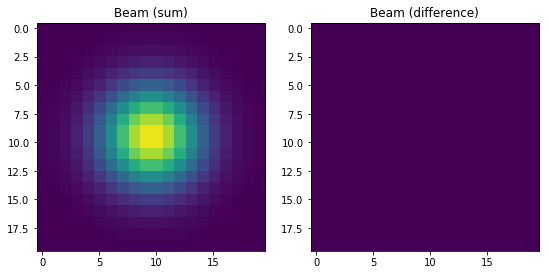

In [4]:
from s4cmb.instrument import construct_beammap

beam = inst.beam_model
summap, diffmap = construct_beammap(
    beam, ct=0, cb=1, nx=20, 
    pix_size=0.5 / 180. * np.pi / 60.)

fig, ax = pl.subplots(1,2, figsize=(9, 5))
ax[0].imshow(summap, vmin=0, vmax=1)
ax[0].set_title('Beam (sum)')
ax[1].imshow(diffmap, vmin=0, vmax=1e-10)
ax[1].set_title('Beam (difference)')
pl.show()

As expected, the difference beam is zero (the two detector beams are identical for the moment)
We will see later how to perturbed the beams, and generate spurious signals from beam mismatch.

** Pointing model **

We also have access to the pointing model of the telescope.
We focus by default on a five-parameter pointing model (Mangum 2001) to
characterize the relationship between the telescope's encoder
readings and its true boresight pointing on the sky.
The parameters described in this reference are
* IA, the azimuth encoder zero offset,
* IE, the elevation encoder zero offset,
* CA, the collimation error of the electromagnetic axis,
* AN, the azimuth axis offset/misalignment (north-south) and
* AW, the azimuth offset/misalignment (east-west).

In [5]:
pm = inst.pointing_model
[(i, round(j,3)) for i, j in zip(pm.allowed_params.split(), pm.value_params)]

[('ia', -10.285), ('ie', 8.74), ('ca', -15.598), ('an', -0.51), ('aw', 0.109)]

Note that those values are currently harcoded in the code. 
If you want to change the pointing model, the code has to be changed.

** HWP **

Finally, one can add a Half-Wave Plate (HWP) to our instrument. 
There are two types of HWP available: continously rotated or stepped
Below, we initialise our instrument with the former.

CRHWP @ 2.0 Hz starting at 0.0 deg


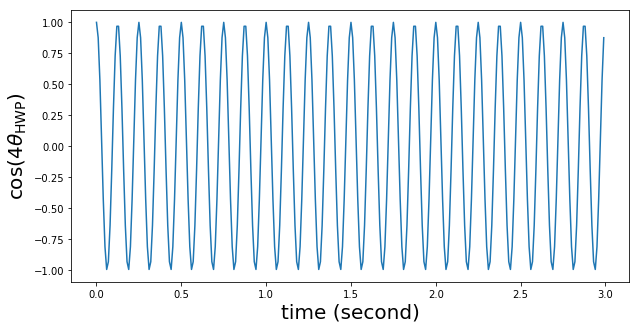

In [6]:
hwp = inst.half_wave_plate
print(hwp.type_hwp, '@', hwp.freq_hwp, 'Hz', 'starting at', hwp.angle_hwp, 'deg')

pl.figure(figsize=(10, 5))
sample_rate, size = 100., 300
hwp_angles = hwp.compute_HWP_angles(sample_rate=sample_rate, size=size)
xaxis = [t/sample_rate for t in range(size)]
pl.plot(xaxis, np.cos(4*hwp_angles), ls='-')
pl.xlabel('time (second)', fontsize=20)
pl.ylabel('cos(4$\\theta_{\\rm{HWP}}$)', fontsize=20)
pl.show()


Note that the routine compute_HWP_angles() returns increasing value of the angle, that is values not
between 0 and 2pi. So if needed, you have to clip values first.

In [7]:
print(hwp_angles[::20] * 180. / np.pi)
print(hwp_angles[::20] % (2 * np.pi) * 180. / np.pi)

[    0.   144.   288.   432.   576.   720.   864.  1008.  1152.  1296.
  1440.  1584.  1728.  1872.  2016.]
[   0.  144.  288.   72.  216.    0.  144.  288.   72.  216.    0.  144.
  288.   72.  216.]


A stepped HWP is easily generated by setting the frequency of rotation to zero.
Alternatively, one can update the behaviour of the HWP on-the-fly.

In [8]:
hwp.update_hardware(new_type_hwp='stepped', new_freq_hwp=0.0, new_angle_hwp=20.0)
hwp_angles = hwp.compute_HWP_angles(sample_rate=sample_rate, size=size)
print(hwp_angles[:10] * 180. / np.pi)

[ 20.  20.  20.  20.  20.  20.  20.  20.  20.  20.]


It can be useful to simulate hardware problems over some period of time for example!